In [1]:
import os
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils
import torch.utils.data as data_utils
import matplotlib.pyplot as plt

from GAN import Generator, Discriminator

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [3]:
num_epochs = 6000
batch_size = 64
d_lr = 8e-4
g_lr = 4e-4
image_save_path = './images/gan/'
model_save_path = './gan_camel.pth'
os.makedirs(image_save_path, exist_ok=True)

In [4]:
class MyDataset(Dataset):
    def __init__(self, data):
        super(MyDataset, self).__init__()
        self.data = data
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

In [5]:
# data url: https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap?pli=1
train_data = np.load('../data/full_numpy_bitmap_camel.npy')
train_data = (train_data.astype('float32') - 127.5) / 127.5
train_data = train_data.reshape(-1, 1, 28, 28)
np.random.seed(np.random.randint(1, 10e6))
np.random.shuffle(train_data)
train_data = torch.from_numpy(train_data[:80000]).float()
dataset = MyDataset(train_data)
dataloader = DataLoader(dataset,
                        shuffle=True,
                        batch_size=batch_size,
                        num_workers=4,
                        pin_memory=True)

torch.Size([80000, 1, 28, 28])


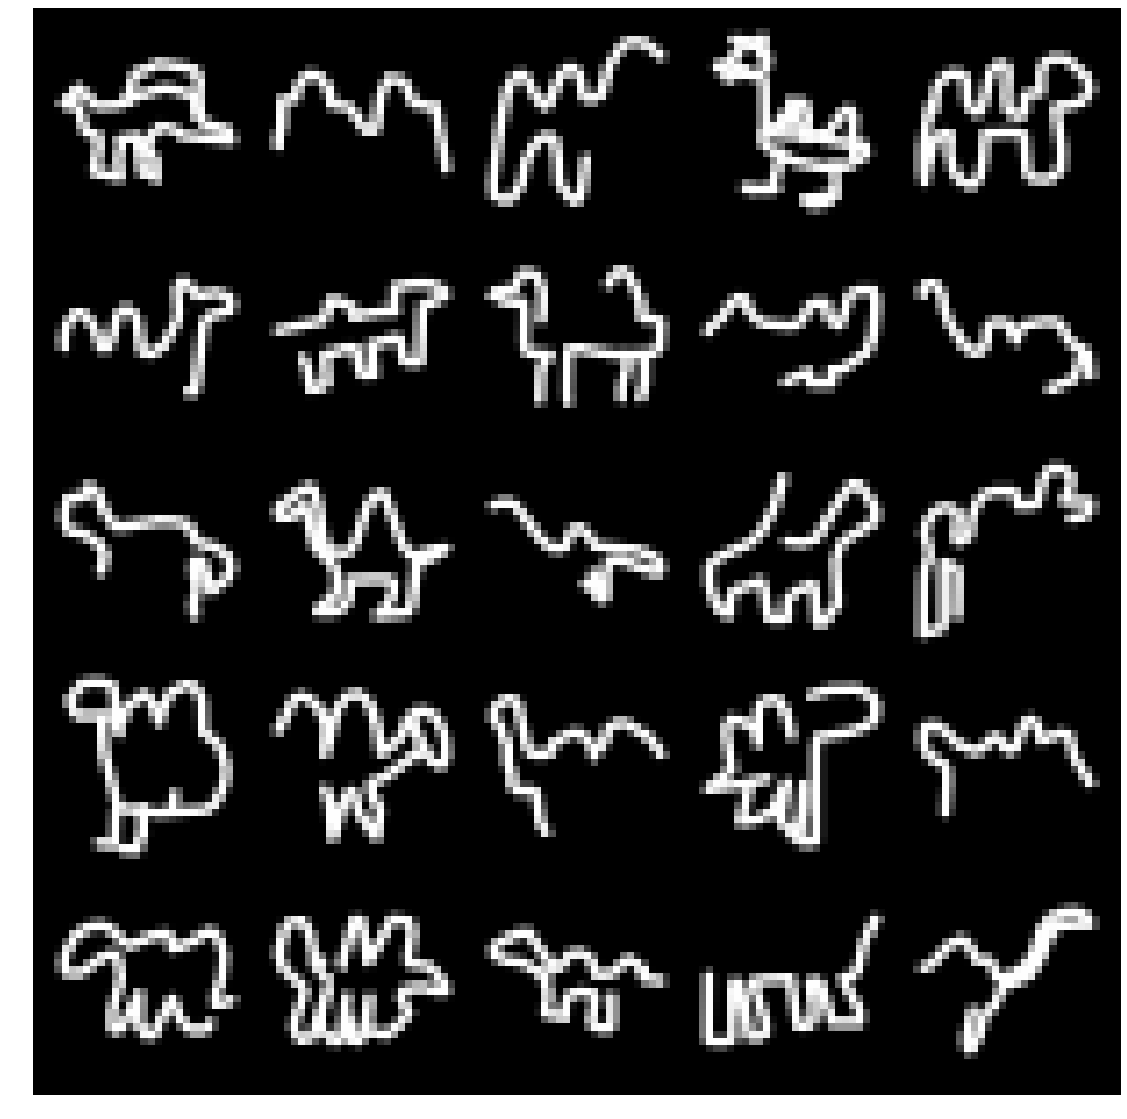

In [6]:
print(train_data.shape)
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(train_data[:25],
                                         nrow=5,
                                         padding=2,
                                         normalize=True), (1, 2, 0)))
plt.savefig(os.path.join(image_save_path, 'original_images.png'))

In [8]:
d_model = Discriminator("cuda:0").to(device)
g_model = Generator("cuda:0").to(device)

In [8]:
print(g_model)

Generator(
  (linear): Linear(in_features=100, out_features=3136, bias=True)
  (batch_norm): BatchNorm1d(3136, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layers): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Upsample(scale_factor=2.0, mode=nearest)
    (5): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Upsample(scale_factor=1.0, mode=nearest)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (

In [9]:
print(d_model)

Discriminator(
  (layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.4, inplace=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.4, inplace=False)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=2048, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [26]:
d_criterion = nn.BCELoss()
g_criterion = nn.BCELoss()

real_label = 1.
fake_label = 0.

D_optimizer = optim.RMSprop(params=d_model.parameters(), lr=d_lr)
G_optimizer = optim.RMSprop(params=g_model.parameters(), lr=g_lr)

0 [D loss: (0.692)(R 0.692, F 0.691)] [D acc: (0.501)(0.500, 0.501)] [G loss: 0.020]
1 [D loss: (31.353)(R 0.000, F 62.706)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.665]
2 [D loss: (0.692)(R 0.658, F 0.726)] [D acc: (0.501)(0.518, 0.484)] [G loss: 0.640]
3 [D loss: (0.688)(R 0.621, F 0.755)] [D acc: (0.504)(0.538, 0.470)] [G loss: 0.622]
4 [D loss: (0.693)(R 0.589, F 0.798)] [D acc: (0.503)(0.555, 0.450)] [G loss: 0.663]
5 [D loss: (0.687)(R 0.647, F 0.728)] [D acc: (0.503)(0.524, 0.483)] [G loss: 0.588]
6 [D loss: (0.699)(R 0.565, F 0.832)] [D acc: (0.502)(0.569, 0.435)] [G loss: 0.697]
7 [D loss: (0.691)(R 0.689, F 0.693)] [D acc: (0.501)(0.502, 0.500)] [G loss: 0.657]
8 [D loss: (0.688)(R 0.620, F 0.757)] [D acc: (0.504)(0.538, 0.469)] [G loss: 0.613]
9 [D loss: (0.689)(R 0.594, F 0.784)] [D acc: (0.505)(0.552, 0.457)] [G loss: 0.648]
10 [D loss: (0.684)(R 0.630, F 0.738)] [D acc: (0.506)(0.533, 0.478)] [G loss: 0.603]
11 [D loss: (0.694)(R 0.581, F 0.808)] [D acc: (0.503)(0.560, 

Traceback (most recent call last):
  File "/home/kjh/anaconda3/envs/gan_env/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/kjh/anaconda3/envs/gan_env/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/kjh/anaconda3/envs/gan_env/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/kjh/anaconda3/envs/gan_env/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-v9dp70k2'


2668 [D loss: (0.480)(R 0.477, F 0.483)] [D acc: (0.654)(0.661, 0.648)] [G loss: 1.331]
2669 [D loss: (0.500)(R 0.515, F 0.486)] [D acc: (0.653)(0.654, 0.652)] [G loss: 1.254]
2670 [D loss: (0.557)(R 0.499, F 0.614)] [D acc: (0.632)(0.674, 0.590)] [G loss: 1.322]
2671 [D loss: (0.576)(R 0.643, F 0.509)] [D acc: (0.634)(0.608, 0.661)] [G loss: 1.112]
2672 [D loss: (0.511)(R 0.448, F 0.574)] [D acc: (0.655)(0.680, 0.630)] [G loss: 1.425]
2673 [D loss: (0.523)(R 0.689, F 0.357)] [D acc: (0.640)(0.561, 0.718)] [G loss: 1.026]
2674 [D loss: (0.547)(R 0.408, F 0.687)] [D acc: (0.621)(0.703, 0.539)] [G loss: 1.255]
2675 [D loss: (0.523)(R 0.477, F 0.570)] [D acc: (0.636)(0.668, 0.604)] [G loss: 1.659]
2676 [D loss: (0.579)(R 0.758, F 0.399)] [D acc: (0.617)(0.529, 0.705)] [G loss: 0.929]
2677 [D loss: (0.530)(R 0.355, F 0.704)] [D acc: (0.640)(0.735, 0.545)] [G loss: 1.360]
2678 [D loss: (0.481)(R 0.603, F 0.359)] [D acc: (0.662)(0.607, 0.716)] [G loss: 1.089]
2679 [D loss: (0.524)(R 0.380, F

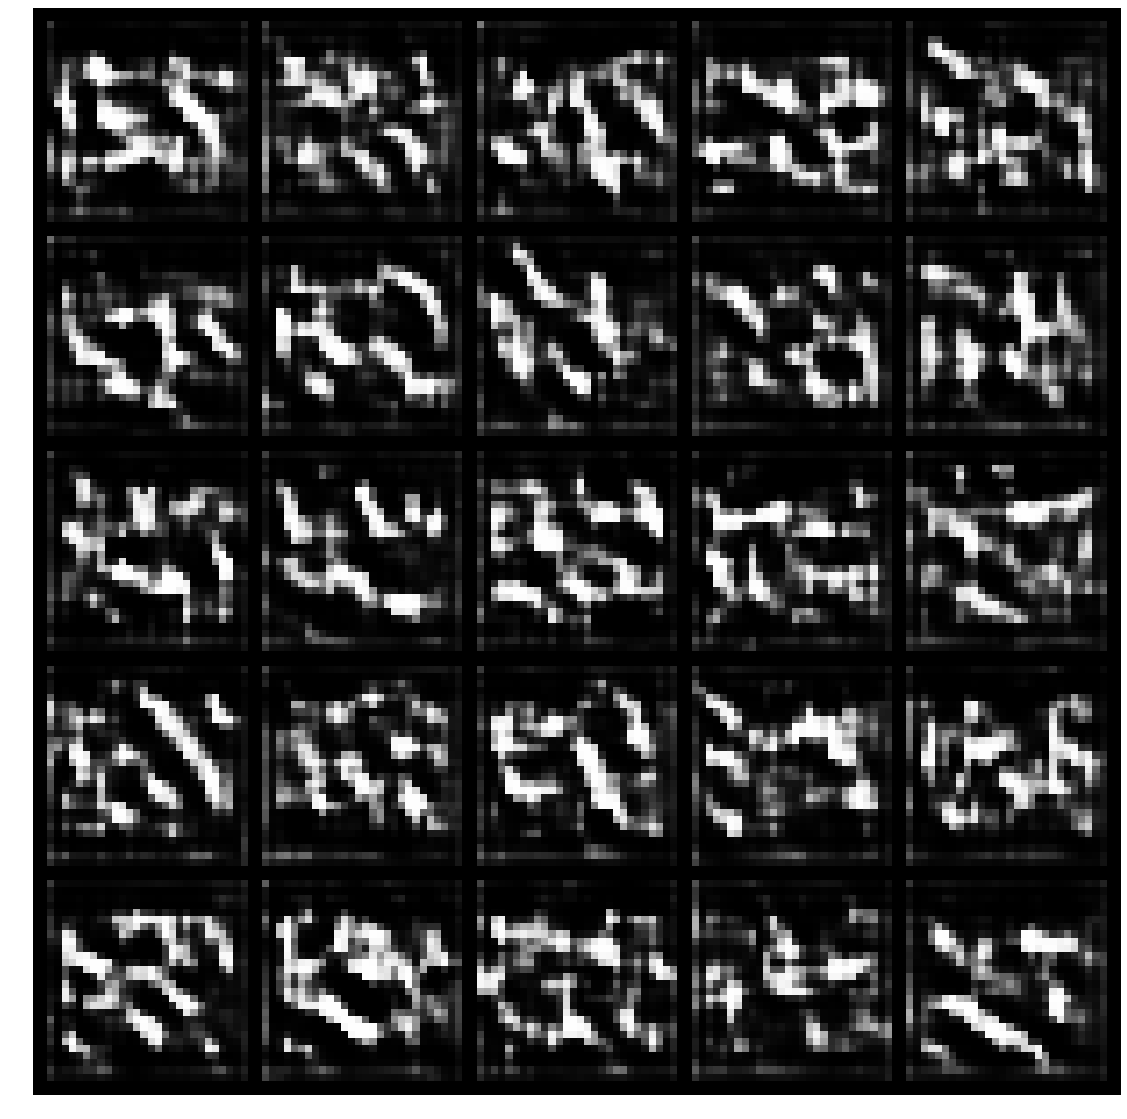

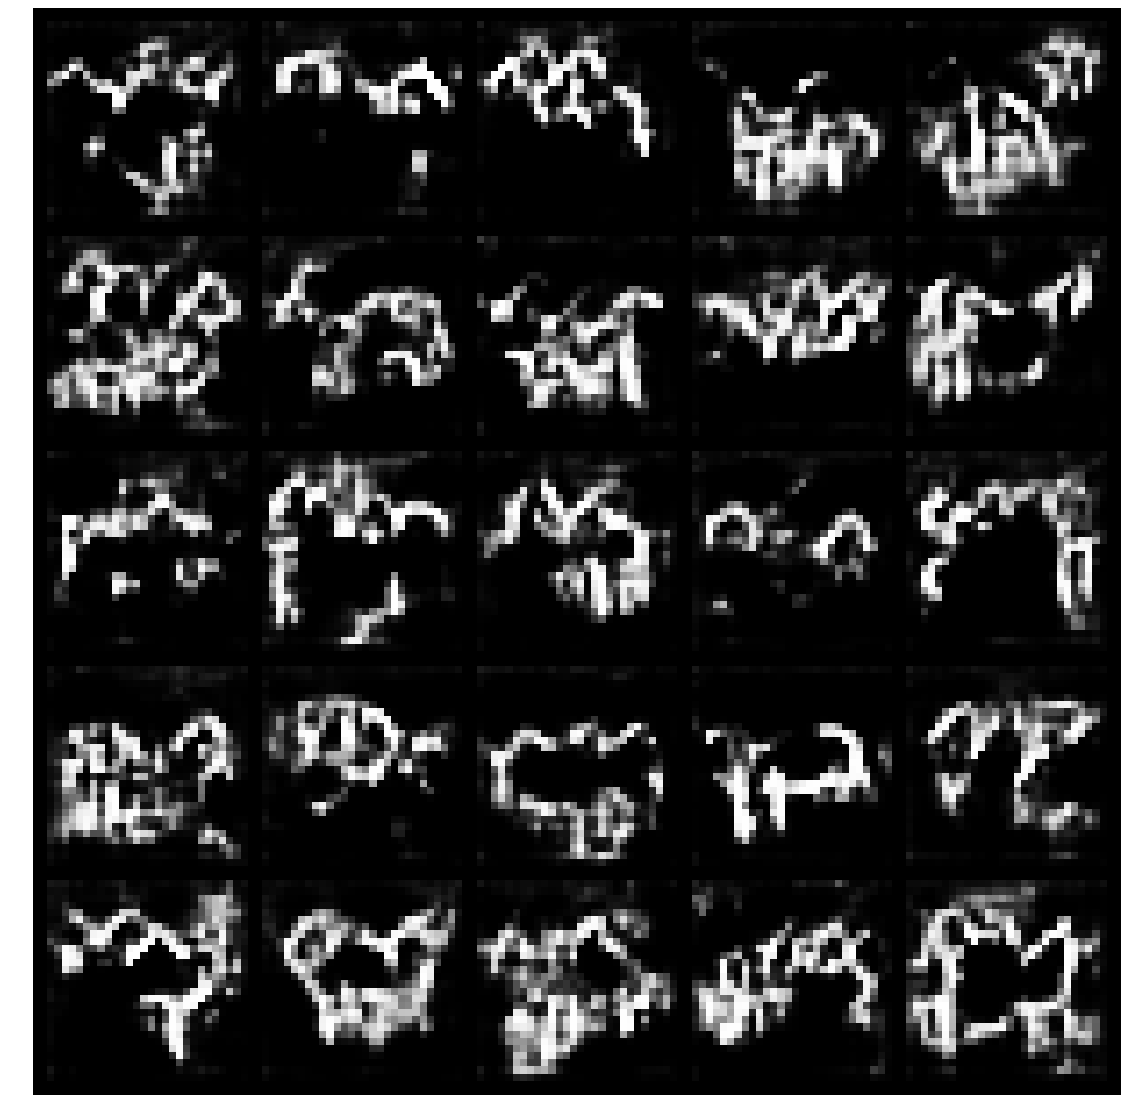

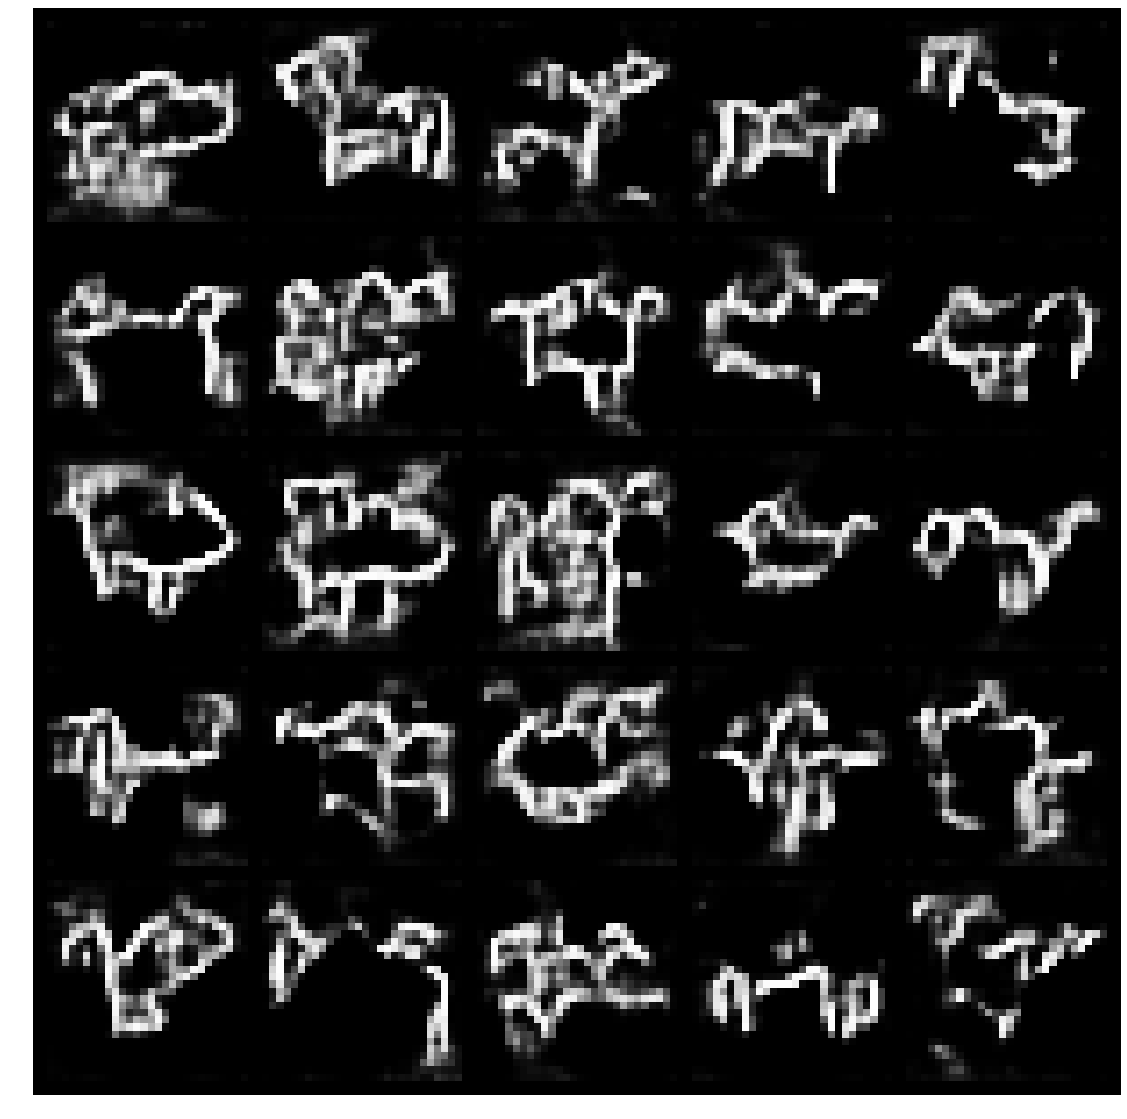

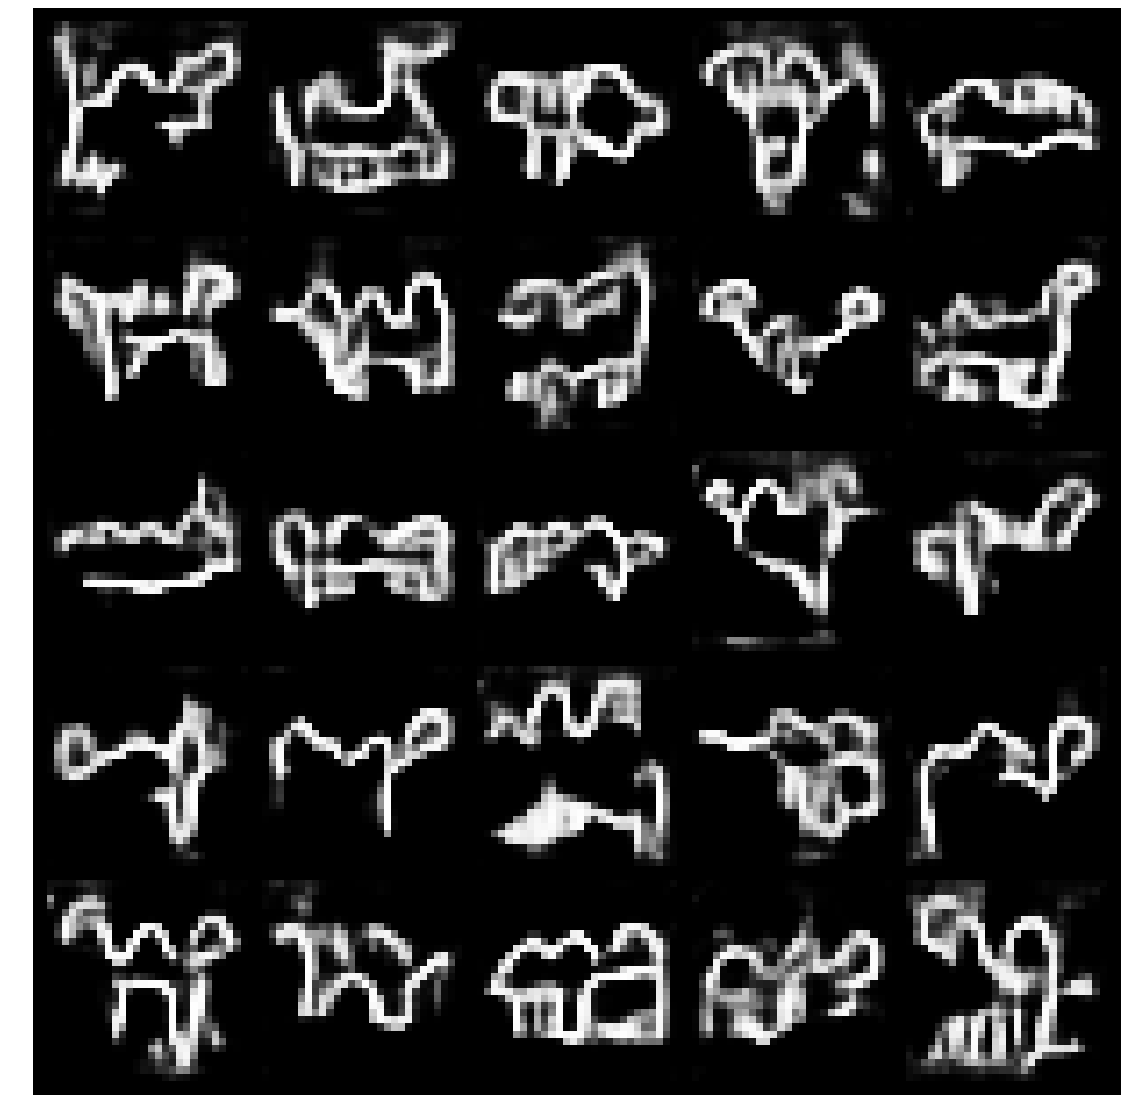

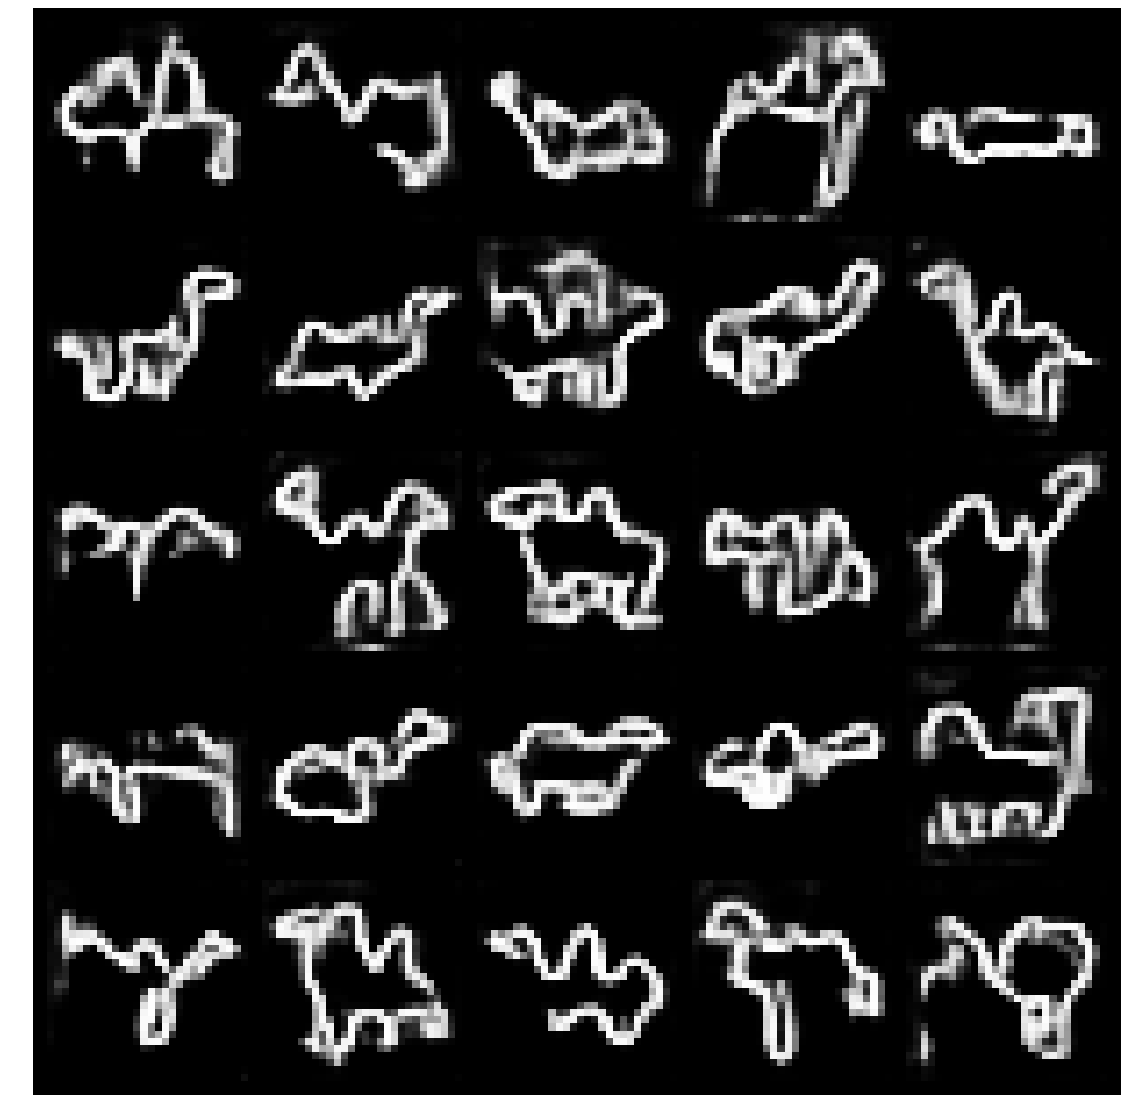

In [27]:
G_losses = []
D_losses = []
D_losses_real = []
D_losses_fake = []
D_accs = []
D_accs_real = []
D_accs_fake = []

for epoch in range(num_epochs):
    data = next(iter(dataloader))
    d_model.zero_grad()
    
    # Discriminator
    # 진짜 데이터로 학습
    inputs = data.to(device)
    b_size = inputs.size(0)
    label = torch.full((b_size, ), real_label,
                        dtype=torch.float, device=device)
    output = d_model(inputs).view(-1)
    D_acc_real = torch.mean(output)
    D_loss_real = d_criterion(output, label)
    
    # 가짜 데이터로 학습
    noise = torch.randn(b_size, 100, device=device)
    fake = g_model(noise)
    label.fill_(fake_label)
    
    output = d_model(fake.detach()).view(-1)
    D_acc_fake = 1 - torch.mean(output)
    D_loss_fake = d_criterion(output, label)
    
    D_acc = (D_acc_real + D_acc_fake) * 0.5
    D_loss = (D_loss_real + D_loss_fake) * 0.5
    D_loss.backward()
    D_optimizer.step()
    
    # Generator
    # 업데이트한 discriminator 사용
    # discriminator가 fake를 real이라고 판단하면 낮은 loss
    # fake를 fake라고 판단하면 높은 loss
    g_model.zero_grad()
    label.fill_(real_label)
    output = d_model(fake).view(-1)
    G_loss = g_criterion(output, label)
    G_loss.backward()
    G_optimizer.step()
    
    G_losses.append(G_loss.item())
    D_losses.append(D_loss.item())
    D_losses_real.append(D_loss_real)
    D_losses_fake.append(D_loss_fake)
    D_accs.append(D_acc.item())
    D_accs_real.append(D_acc_real)
    D_accs_fake.append(D_acc_fake)
    
    print('%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f]' %
              (epoch, D_loss, D_loss_real, D_loss_fake, D_acc, D_acc_real, D_acc_fake, G_loss))
        
    if epoch + 1 in [20, 200, 400, 1000, 2000, 6000]:
        plt.figure(figsize=(20, 20))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(fake[:25],
                                                 nrow=5,
                                                 padding=2,
                                                 normalize=True).detach().cpu(), (1, 2, 0)))
        plt.savefig(os.path.join(image_save_path, f'epoch_{epoch + 1}.png'))
        
        torch.save({'d': d_model.state_dict(), 'g': g_model.state_dict(),}, model_save_path)
        

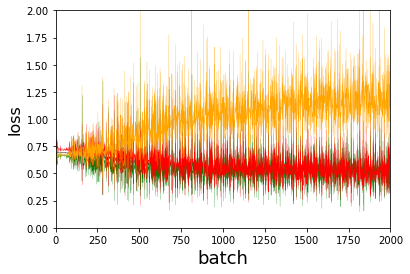

In [28]:
fig = plt.figure()
plt.plot([x for x in D_losses], color='black', linewidth=0.25)
plt.plot([x for x in D_losses_real], color='green', linewidth=0.25)
plt.plot([x for x in D_losses_fake], color='red', linewidth=0.25)
plt.plot([x for x in G_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
plt.ylim(0, 2)

plt.savefig(os.path.join(image_save_path, 'loss_graph.png'))

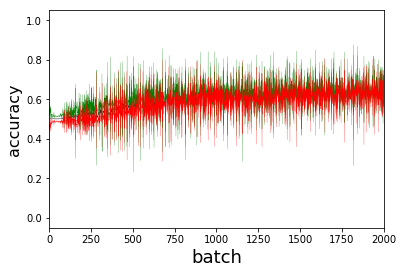

In [29]:
fig = plt.figure()
plt.plot([x for x in D_accs], color='black', linewidth=0.25)
plt.plot([x for x in D_accs_real], color='green', linewidth=0.25)
plt.plot([x for x in D_accs_fake], color='red', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)

plt.xlim(0, 2000)

plt.savefig(os.path.join(image_save_path, 'accuracy_graph.png'))

In [27]:
def l1_compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [9]:
# load
# loaded_models = torch.load(model_save_path)
# d_model.load_state_dict(loaded_models['d'])
# g_model.load_state_dict(loaded_models['g'])

<All keys matched successfully>

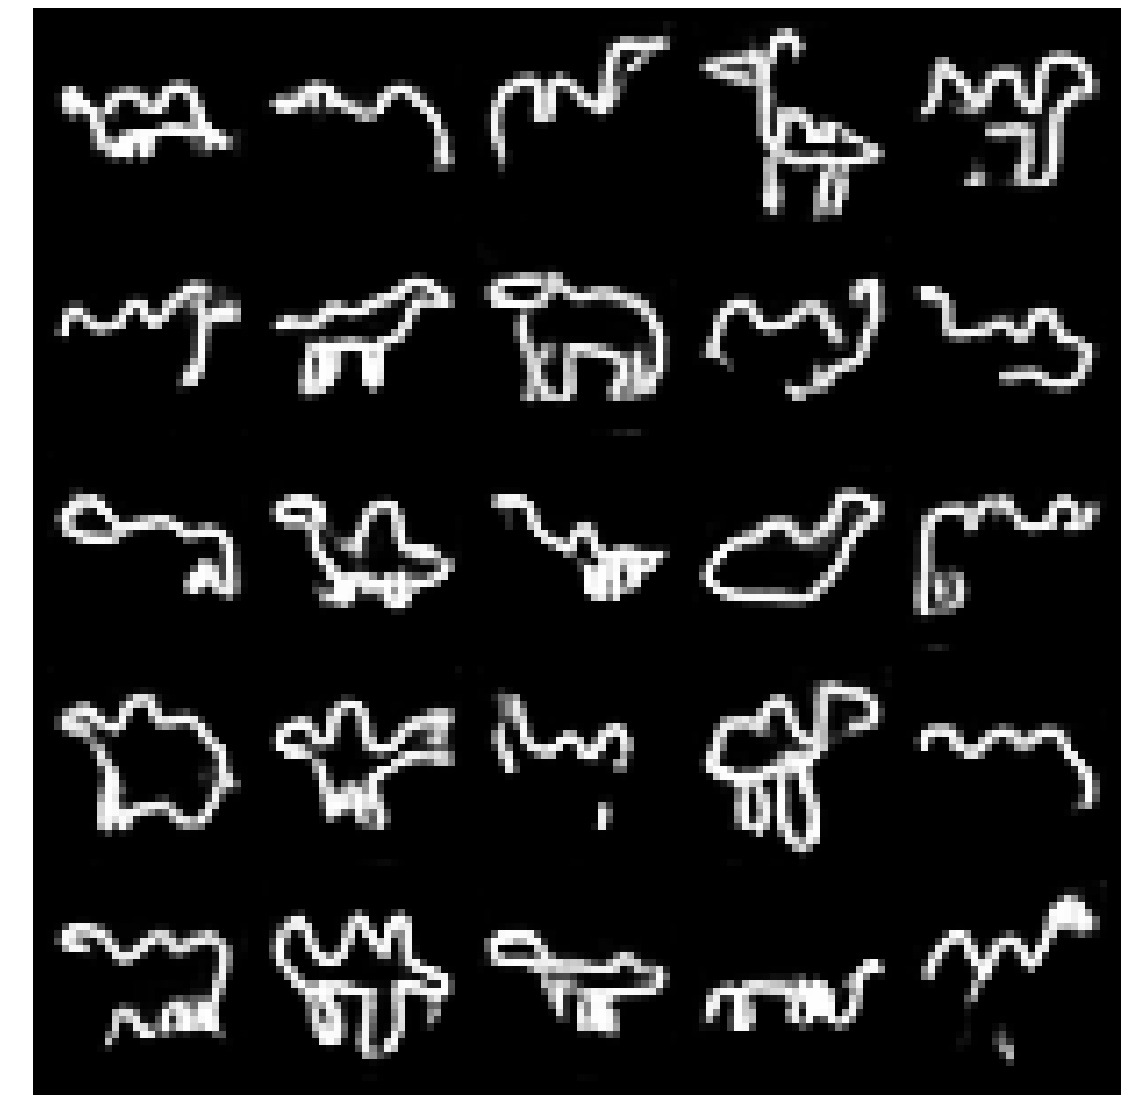

In [31]:
d_model.eval()
g_model.eval()

real_images = train_data[:25].numpy()
fake_images = []

for inputs in dataloader:
    inputs = inputs.to(device)
    b_size = inputs.size(0)
    
    with torch.no_grad():
        noise = torch.randn(b_size, 100, device=device)
        fake = g_model(noise)
        for fake_image in fake:
            fake_images.append(fake_image.detach().cpu().numpy())
    
similar_images = np.zeros(real_images.shape)
for i, real_image in enumerate(real_images):
    min_val = l1_compare_images(real_image, fake_images[0])
    similar_image = fake_images[0]
    for fake_image in fake_images[1:]:
        l1_dist = l1_compare_images(real_image, fake_image)
        if l1_dist < min_val:
            min_val = l1_dist
            similar_image = fake_image
            
    similar_images[i] = similar_image
    
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(torch.from_numpy(similar_images),
                                         nrow=5,
                                         padding=2,
                                         normalize=True), (1, 2, 0)))
plt.savefig(os.path.join(image_save_path, 'similar_images.png'))

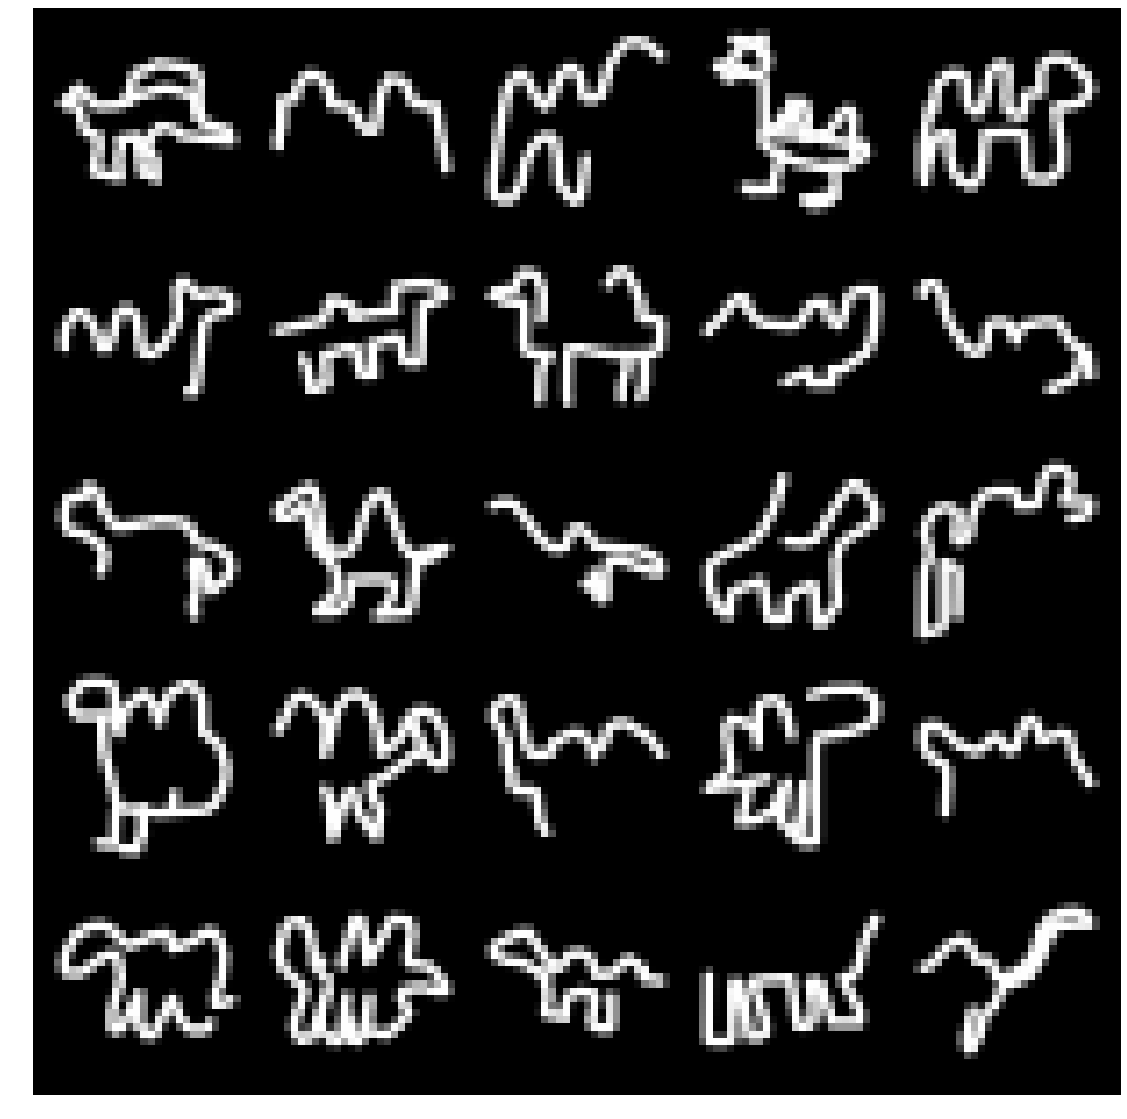

In [32]:
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(train_data[:25],
                                         nrow=5,
                                         padding=2,
                                         normalize=True), (1, 2, 0)))
plt.savefig(os.path.join(image_save_path, 'original_images.png'))